In [36]:
# Train modelimport json
import random
import os
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog
from detectron2.engine import hooks

# Constants
COCO_JSON = "/home/divya/ACPS_Dataset/Dataset/converted_coco_annotations.json"
IMAGE_DIR = "/home/divya/ACPS_Dataset/Dataset/images"
OUTPUT_DIR = "/home/divya/CHILLIE/models/output"
DATASET_DIR = "."

# Load COCO annotations
with open(COCO_JSON) as f:
    coco = json.load(f)

all_images = coco['images']
random.shuffle(all_images)
n = len(all_images)

train_imgs = all_images[:int(0.7 * n)]
val_imgs = all_images[int(0.7 * n):int(0.9 * n)]
test_imgs = all_images[int(0.9 * n):]

# Helper to create and register COCO-format subsets
def create_sub_coco(name, image_subset):
    img_ids = {img['id'] for img in image_subset}
    anns = [ann for ann in coco['annotations'] if ann['image_id'] in img_ids]
    subset = {
        "images": image_subset,
        "annotations": anns,
        "categories": coco['categories']
    }
    json_path = os.path.join(DATASET_DIR, f"{name}_subset.json")
    with open(json_path, 'w') as f:
        json.dump(subset, f)
    register_coco_instances(name, {}, json_path, IMAGE_DIR)

# Register train/val/test subsets
create_sub_coco("chilly_train", train_imgs)
create_sub_coco("chilly_val", val_imgs)
create_sub_coco("chilly_test", test_imgs)

# Configure model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("chilly_train",)
cfg.DATASETS.TEST = ("chilly_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class: chilly
cfg.OUTPUT_DIR = OUTPUT_DIR
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Custom Trainer to skip TensorBoard hook
class CustomTrainer(DefaultTrainer):
    def build_hooks(self):
        hooks_list = super().build_hooks()
        # Remove PeriodicWriter hook (includes TensorboardXWriter if enabled)
        hooks_list = [h for h in hooks_list if not isinstance(h, hooks.PeriodicWriter)]
        return hooks_list

# Train model
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[04/17 17:54:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[04/17 17:54:10 d2.engine.train_loop]: Starting training from iteration 0
[04/17 18:07:48 d2.engine.hooks]: Overall training speed: 2998 iterations in 0:13:36 (0.2722 s / it)
[04/17 18:07:48 d2.engine.hooks]: Total training time: 0:13:36 (0:00:00 on hooks)
[04/17 18:07:48 d2.data.datasets.coco]: Loaded 553 images in COCO format from ./chilly_val_subset.json
[04/17 18:07:48 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   chilli   | 2758         |
|            |              |
[04/17 18:07:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/17 18:07:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/17 18:07:48 d2.data.common]: Serializing 553 elements to byte tensors and concatenating them all ...
[04/17 18:07:48 d2.data.common]: Ser

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[04/17 18:07:49 d2.engine.train_loop]: Starting training from iteration 0
[04/17 18:21:28 d2.engine.hooks]: Overall training speed: 2998 iterations in 0:13:37 (0.2728 s / it)
[04/17 18:21:28 d2.engine.hooks]: Total training time: 0:13:38 (0:00:00 on hooks)
[04/17 18:21:28 d2.data.datasets.coco]: Loaded 553 images in COCO format from ./chilly_val_subset.json
[04/17 18:21:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/17 18:21:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/17 18:21:28 d2.data.common]: Serializing 553 elements to byte tensors and concatenating them all ...
[04/17 18:21:28 d2.data.common]: Serialized dataset takes 0.19 MiB
WARNING [04/17 18:21:28 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.


Dynamic threshold selected: 0.4795


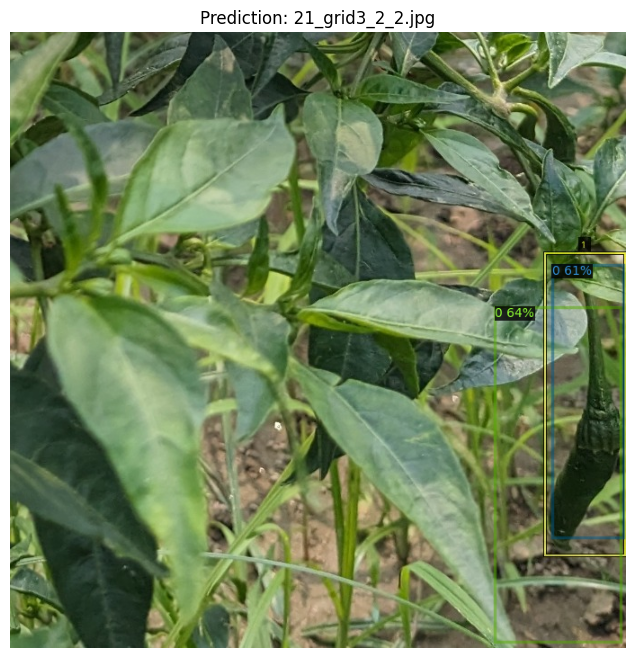

In [33]:
import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.model_zoo import get_config_file

# Load model config
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = "/home/divya/CHILLIE/models/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # Start with 0 and adjust dynamically
cfg.DATASETS.TEST = ("chilly_val", )
cfg.MODEL.DEVICE = "cuda:1"


predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get("chilly_val")

# Directory containing unseen test images
unseen_images_dir = "/home/divya/CHILLIE/images/test"
unseen_images = [f for f in os.listdir(unseen_images_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Choose one random image for prediction
img_name = random.choice(unseen_images)
img_path = os.path.join(unseen_images_dir, img_name)
im = cv2.imread(img_path)
outputs = predictor(im)

# Calculate dynamic threshold based on predicted scores (mean of top-k scores)
scores = outputs["instances"].scores.cpu().numpy()
if len(scores) > 0:
    k = min(5, len(scores))  # Use top-k highest scores (up to 5)
    threshold =  np.clip(np.mean(sorted(scores, reverse=True)[:k]), 0.2, 0.5)  # Compute threshold from top-k
    print(f"Dynamic threshold selected: {threshold:.4f}")
else:
    threshold = 0.2  # fallback threshold if no predictions

# Apply the dynamic threshold
outputs["instances"] = outputs["instances"][outputs["instances"].scores > threshold]

# Visualize predictions
v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(out.get_image())
plt.title(f"Prediction: {img_name}")
plt.axis("off")
plt.show()


Dynamic threshold selected for 76grid40_2.jpg: 0.3868


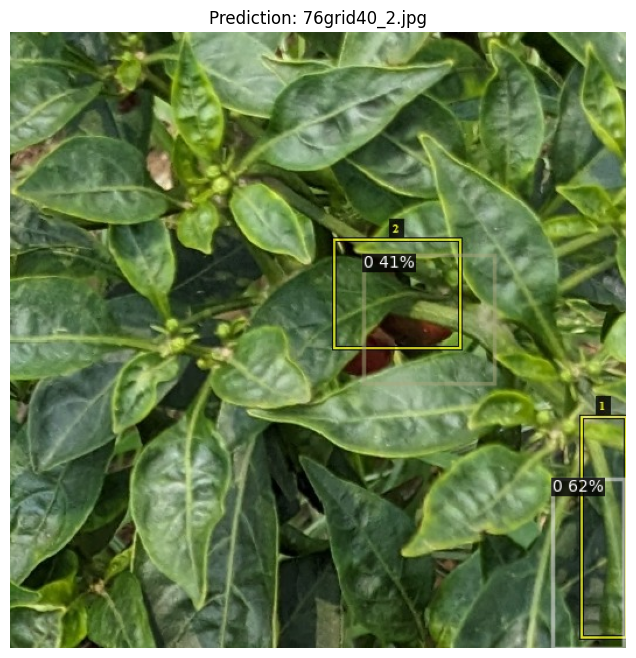

Dynamic threshold selected for 47grid40_1.jpg: 0.4226


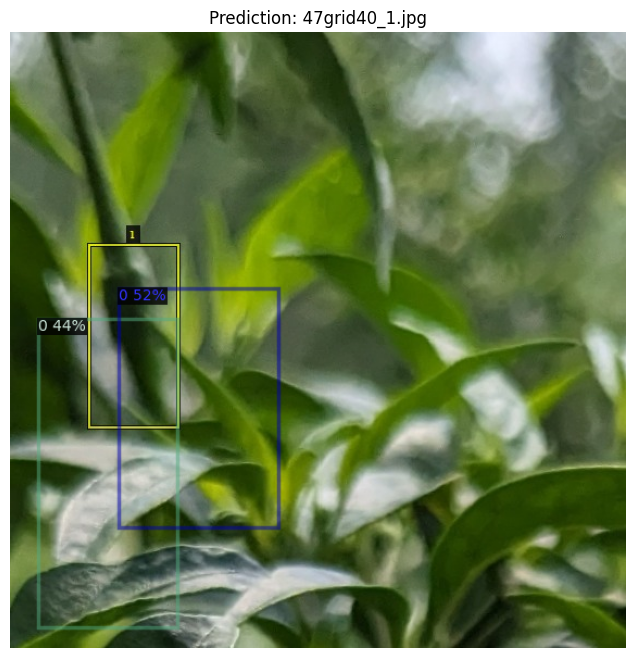

Dynamic threshold selected for 59grid32_1.jpg: 0.2412


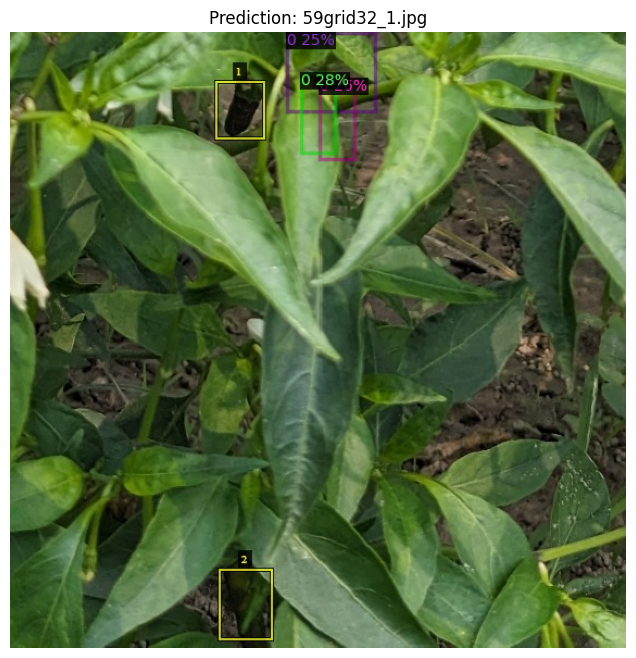

Dynamic threshold selected for 57grid30_1.jpg: 0.3030


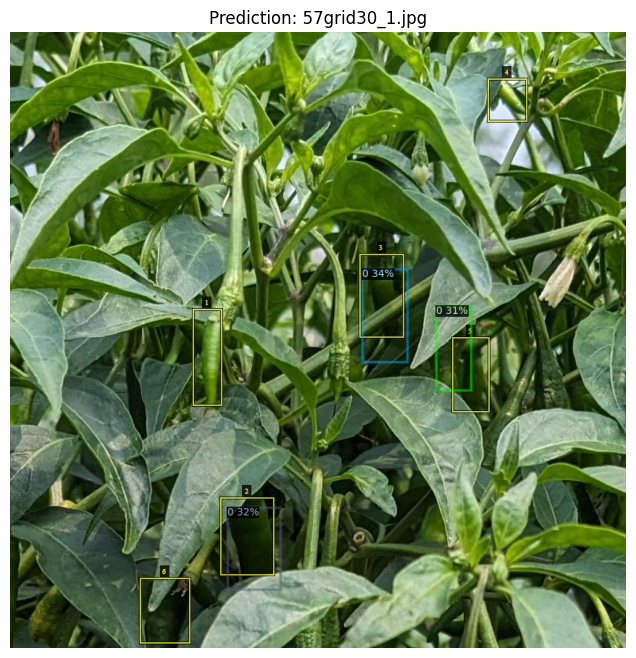

In [35]:
import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.model_zoo import get_config_file

# Load model config
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = "/home/divya/CHILLIE/models/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # Start with 0 and adjust dynamically
cfg.DATASETS.TEST = ("chilly_val", )
cfg.MODEL.DEVICE = "cuda:1"


predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get("chilly_val")

# Directory containing unseen test images
unseen_images_dir = "/home/divya/CHILLIE/images/test"
unseen_images = [f for f in os.listdir(unseen_images_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Select 3 or 4 random images for prediction
num_images = 4  # Set to 3 or 4 as needed
selected_images = random.sample(unseen_images, num_images)

# Loop through each selected image
for img_name in selected_images:
    img_path = os.path.join(unseen_images_dir, img_name)
    im = cv2.imread(img_path)
    outputs = predictor(im)

    # Calculate dynamic threshold based on predicted scores (mean of top-k scores)
    scores = outputs["instances"].scores.cpu().numpy()
    if len(scores) > 0:
        k = min(5, len(scores))  # Use top-k highest scores (up to 5)
        threshold =  np.clip(np.mean(sorted(scores, reverse=True)[:k]), 0.2, 0.5)  # Compute threshold from top-k
        print(f"Dynamic threshold selected for {img_name}: {threshold:.4f}")
    else:
        threshold = 0.2  # fallback threshold if no predictions

    # Apply the dynamic threshold
    outputs["instances"] = outputs["instances"][outputs["instances"].scores > threshold]

    # Visualize predictions
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display the result
    plt.figure(figsize=(10, 8))
    plt.imshow(out.get_image())
    plt.title(f"Prediction: {img_name}")
    plt.axis("off")
    plt.show()


[04/17 18:27:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/divya/CHILLIE/models/output/model_final.pth ...
[04/17 18:27:48 d2.data.datasets.coco]: Loaded 553 images in COCO format from ./chilly_val_subset.json
Dynamic threshold selected: 0.2323
Prediction accuracy: 0.00%


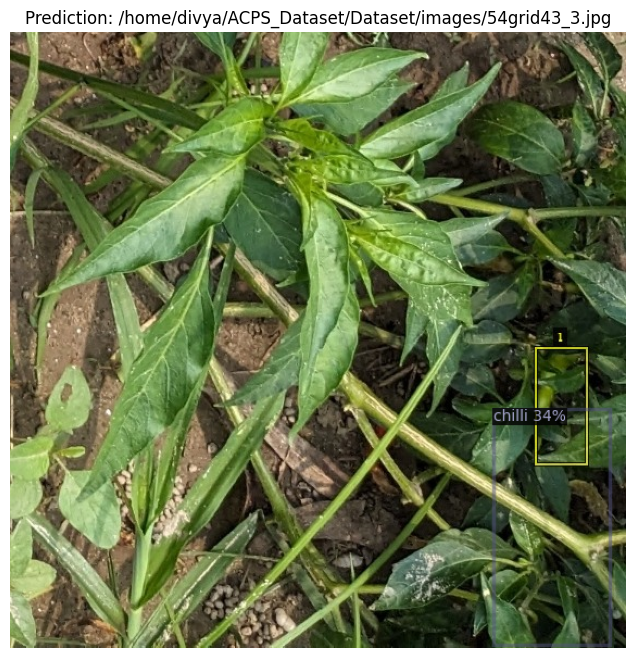

In [45]:
import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.model_zoo import get_config_file
from detectron2.data.datasets import load_coco_json

# Function to calculate IoU between two bounding boxes
def compute_iou(box1, box2):
    # Box format: [x1, y1, x2, y2]
    x1, y1, x2, y2 = box1
    x1_gt, y1_gt, x2_gt, y2_gt = box2

    # Calculate intersection area
    ix1 = max(x1, x1_gt)
    iy1 = max(y1, y1_gt)
    ix2 = min(x2, x2_gt)
    iy2 = min(y2, y2_gt)

    inter_area = max(0, ix2 - ix1) * max(0, iy2 - iy1)

    # Calculate union area
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_gt - x1_gt) * (y2_gt - y2_gt)

    union_area = box1_area + box2_area - inter_area

    # Calculate IoU
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

# Load model config
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = "/home/divya/CHILLIE/models/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # Start with 0 and adjust dynamically
cfg.DATASETS.TEST = ("chilly_val", )

predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get("chilly_val")

# Load the COCO dataset annotations for validation set
dataset_dicts = DatasetCatalog.get("chilly_val")

# Choose one random image from the dataset
img_name = random.choice(dataset_dicts)
img_path = img_name["file_name"]
im = cv2.imread(img_path)

# Get ground truth boxes for the selected image
ground_truth_boxes = []
for annotation in img_name["annotations"]:
    # Extract the bounding box (x1, y1, x2, y2)
    bbox = annotation["bbox"]  # COCO format [x, y, width, height]
    x1, y1, width, height = bbox
    x2 = x1 + width
    y2 = y1 + height
    ground_truth_boxes.append([x1, y1, x2, y2])

# Get predictions from the model
outputs = predictor(im)

# Set a dynamic threshold based on predicted scores (mean of top-k scores)
scores = outputs["instances"].scores.cpu().numpy()
if len(scores) > 0:
    k = min(5, len(scores))  # Use top-k highest scores (up to 5)
    threshold = np.mean(sorted(scores, reverse=True)[:k])  # Compute threshold from top-k
    print(f"Dynamic threshold selected: {threshold:.4f}")
else:
    threshold = 0.2  # fallback threshold if no predictions

# Apply the dynamic threshold
outputs["instances"] = outputs["instances"][outputs["instances"].scores > threshold]

# Extract predicted boxes
pred_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()

# Calculate accuracy based on IoU threshold (e.g., 0.5)
iou_threshold = 0.5
correct_predictions = 0
total_predictions = len(pred_boxes)

for pred_box in pred_boxes:
    best_iou = 0
    for gt_box in ground_truth_boxes:
        iou = compute_iou(pred_box, gt_box)
        best_iou = max(best_iou, iou)

    # If IoU is greater than the threshold, count it as correct
    if best_iou > iou_threshold:
        correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f"Prediction accuracy: {accuracy * 100:.2f}%")

# Visualize predictions
v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(out.get_image())
plt.title(f"Prediction: {img_name['file_name']}")
plt.axis("off")
plt.show()


In [12]:
import os
print("Saving predictions to:", os.getcwd())


Saving predictions to: /home/divya/CHILLIE/models


In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("chilly_test", cfg, False, output_dir="/home/divya/CHILLIE/models/output")
val_loader = build_detection_test_loader(cfg, "chilly_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


WARNING [04/17 17:39:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/17 17:39:41 d2.data.datasets.coco]: Loaded 276 images in COCO format from ./chilly_test_subset.json
[04/17 17:39:41 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   chilli   | 1247         |
|            |              |
[04/17 17:39:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/17 17:39:41 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/17 17:39:41 d2.data.common]: Serializing 276 elements to byte tensors and concatenating them all ...
[04/17 17:39:41 d2.data.common]: Serialized dataset takes 0.09 MiB
[04/17 17:39:41 d2.evaluation.evaluator]: Start inferen